# Examples of ordinary differential equation discovery with EPDE framework

This notebook presents an overview of the evolutionary discovery of ODE on examples... 

In [7]:
import numpy as np
import os
import sys
from typing import Union, Callable

import matplotlib.pyplot as plt
import matplotlib as mpl

ADD SOME LINK TO ARTICLE ON EPDE PRINCIPLES

In [8]:
import sys
sys.path.append('..')
import helpers

In [9]:
import epde

In [10]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = False

SMALL_SIZE = 12
mpl.rc('font', size=SMALL_SIZE)
mpl.rc('axes', titlesize=SMALL_SIZE)

## First order ODE with trigonometric functions

Principles of equation discovery can be illustrated by a simple example of reconstruction of first-order equation:

\begin{equation}
\label{eq:ODE1}
x \sin{t} + \frac{d x}{d t} \cos{t} = 1,
\end{equation}

where the general solution for an arbitrary constant $C$ is:

\begin{equation}
\label{eq:ODE1_solution}
x = \sin{t} + C \cos{t}.
\end{equation}

To generate the data we will use an analytical particular solution, matching initial condition of $x(0) = 1.3$ (thus, $C = 1.3$) on the interval of $(0, 4 \pi)$:

\begin{equation}
\label{eq:ODE1_part_solution}
x = \sin{t} + 1.3 \cos{t}.
\end{equation}

Furthermore, we will provide an example of using a priori known derivatvies, that can be easily calculated by differentiating the solution:

\begin{equation}
\label{eq:ODE1_deriv_solution}
x' = \cos{t} - 1.3 \sin{t}.
\end{equation}

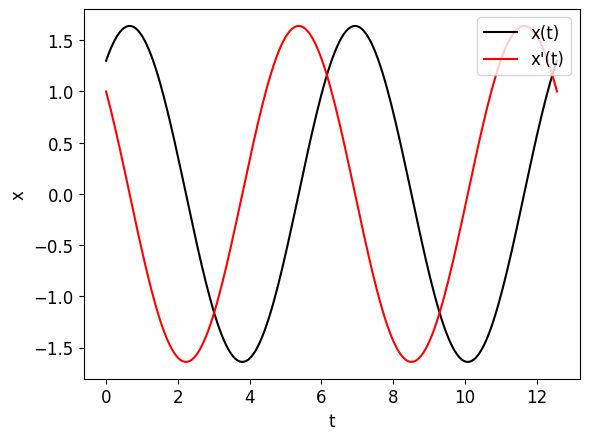

In [11]:
C = 1.3
t = np.linspace(0, 4*np.pi, 200)
x = np.sin(t) + C * np.cos(t)
x_dot = np.cos(t) - C * np.sin(t)
x_dot_dot = -np.sin(t) - C * np.cos(t)
max_axis_idx = x.ndim - 1

plt.plot(t, x, color = 'k', label = 'x(t)')
plt.plot(t, x_dot, color = 'r', label = "x'(t)")

plt.legend(loc = 'upper right')
plt.xlabel('t')
plt.ylabel('x')
plt.show()

In [12]:
x_n = x + np.random.normal(0, np.abs(0.1*x), x.size)

In [16]:
import epde.globals as global_var

global_var.reset_data_repr_nn(data=[x,], grids=[t,], derivs = [[0, [0,], x_dot],],  #  [0, [0,0], x_dot_dot]
                              epochs_max=100000, batch_frac=1., learining_rate=1e-4)

min loss is 0.2439601570367813, in last epoch: [0.32892680168151855], 


In [17]:
from copy import deepcopy
sobolev_nn = deepcopy(global_var.solution_guess_nn)

In [18]:
global_var.reset_data_repr_nn(data=[x,], grids=[t,], epochs_max=100000, batch_frac=0.5, learining_rate=1e-4)
base_nn = deepcopy(global_var.solution_guess_nn)

min loss is 0.0013299534912221134, in last epoch: [0.007084044627845287, 0.007490743882954121], 


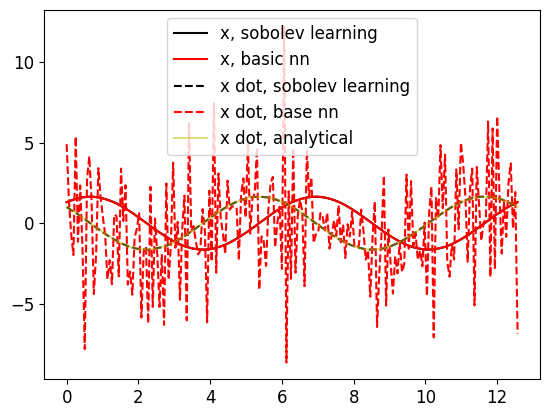

(200,) (200, 1) (200, 1)
MAE for sobolev nn: 0.003163033091877285 and for basic 0.005279670612936559


In [22]:
import torch
differentiator = global_var.AutogradDeriv()

sobolev_pred = sobolev_nn(torch.from_numpy(t).reshape((-1, 1)).float()).detach().numpy()
base_pred = base_nn(torch.from_numpy(t).reshape((-1, 1)).float()).detach().numpy()
sobolev_deriv = differentiator.take_derivative(sobolev_nn, grid=torch.from_numpy(t).reshape((-1, 1)).float(), axes=[0,]).detach().numpy()
base_deriv = differentiator.take_derivative(base_nn, grid=torch.from_numpy(t).reshape((-1, 1)).float(), axes=[0,]).detach().numpy()

# plt.plot(t, x, '*', color = 'b', label = 'x, ground truth')
plt.plot(t, sobolev_pred, color = 'k', label = 'x, sobolev learning')
plt.plot(t, base_pred, color = 'r', label = 'x, basic nn')
plt.plot(t, sobolev_deriv, '--', color = 'k', label = 'x dot, sobolev learning')
plt.plot(t, base_deriv, '--', color = 'r', label = 'x dot, base nn')
plt.plot(t, x_dot, '-', alpha=0.5, color = 'y', label = 'x dot, analytical')
plt.legend()
plt.show()

print(x.shape, sobolev_pred.shape, base_pred.shape)
print(f'MAE for sobolev nn: {np.mean(np.abs(x - sobolev_pred.reshape(-1)))} and for basic {np.mean(np.abs(x - base_pred.reshape(-1)))}')



Необходимо проверить корректность определения уравнения и сходимость солвера к корректному решению при 

In [ ]:
s_params = sobolev_nn.parameters()

In [ ]:
for name, param in sobolev_nn.named_parameters():
    if param.requires_grad:
        print(name, param.data)

1.weight tensor([[-0.1638,  0.2179,  0.0632,  ...,  0.0873,  0.1641, -0.0384],
        [-0.0448, -0.1469, -0.1522,  ..., -0.1832, -0.1045, -0.1131],
        [-0.0430, -0.0437, -0.1767,  ...,  0.0088,  0.2179, -0.1769],
        ...,
        [ 0.0464, -0.0482, -0.0434,  ..., -0.0326, -0.0856,  0.0013],
        [ 0.1901, -0.2993,  0.1274,  ..., -0.1958, -0.1815, -0.1592],
        [ 0.2287,  0.0409, -0.0936,  ...,  0.0471, -0.0551,  0.1767]])
1.bias tensor([ 0.0608, -0.1255,  0.1392, -0.1109, -0.0985,  0.1544, -0.0830,  0.0017,
         0.1402,  0.0744,  0.0765, -0.0596, -0.0086, -0.1447,  0.0332,  0.1367,
         0.0557,  0.1599,  0.0583, -0.0974,  0.0590,  0.0621, -0.0707, -0.0533,
        -0.0992,  0.0868,  0.1846, -0.0733, -0.0913, -0.1051, -0.0443, -0.1705,
         0.1354, -0.1785,  0.1882,  0.0992, -0.0576,  0.1245, -0.1959,  0.0948,
         0.1315, -0.1329, -0.1360, -0.1909, -0.0707, -0.0034, -0.0324,  0.1971,
         0.0657,  0.1242, -0.1032, -0.2161, -0.1402,  0.0026, -0.0937,

In [ ]:
for name, param in base_nn.named_parameters():
    if param.requires_grad:
        print(name, param.data)

1.weight tensor([[-0.1549,  0.1779,  0.0427,  ..., -0.1165,  0.1637,  0.2277],
        [ 0.1012,  0.0820,  0.0628,  ..., -0.0295, -0.1836, -0.1896],
        [ 0.2930, -0.0134,  0.0329,  ..., -0.1595,  0.1654, -0.1051],
        ...,
        [ 0.2183,  0.1290, -0.1804,  ...,  0.0836, -0.1708,  0.1290],
        [ 0.0031, -0.0108,  0.0274,  ...,  0.0832, -0.1689,  0.0252],
        [-0.1242, -0.2165, -0.2908,  ..., -0.2727, -0.1393,  0.0805]])
1.bias tensor([ 0.0394,  0.1745,  0.2230,  0.0403,  0.1804,  0.0473, -0.0366,  0.0851,
         0.1480,  0.1941, -0.0516, -0.2334, -0.2105,  0.2151, -0.2298,  0.0721,
        -0.1675, -0.0779,  0.1171, -0.0599,  0.0212, -0.0888,  0.2000, -0.0578,
         0.1436, -0.0598, -0.0664,  0.0510, -0.1899,  0.1417,  0.0466, -0.1537,
         0.0628, -0.1053, -0.0612,  0.1769,  0.1081,  0.1432,  0.1280,  0.0013,
        -0.0818,  0.0266, -0.0369, -0.0433,  0.1058,  0.0079,  0.0746,  0.2297,
         0.0169,  0.0559, -0.1184,  0.0919,  0.1321,  0.1526, -0.2249,

Next, we shall initialize the equation search object. Here we are using multiobjective optimization (here, it i denoted explicitly, despite it being the default option). Non-defalut parameter is the size of the boundary: $s_{bnd} = 20$.

Additional parameters will be as follows  population size number of optimziation epochs: ``n_epochs = 30``.

To be able to discovery the correct governing equation, the set of elementary functions (i.e. tokens) (in addition to the derivatives, that are always used) has to include the trigonometric functions. Furthermore, we will include grid as elementary block to provide diversity of the tokens.

In [ ]:
bnd = 20
n_epochs = 10
popsize = 8

epde_search_obj = epde.EpdeSearch(use_solver=True, multiobjective_mode = True, boundary = bnd, 
                                  dimensionality = max_axis_idx, coordinate_tensors = [t,], 
                                  verbose_params = {'show_iter_idx' : True}) # False for brevity

trig_tokens = epde.TrigonometricTokens(freq = (0.95, 1.05), dimensionality=max_axis_idx)
grid_tokens = epde.GridTokens(['x_0',], dimensionality = max_axis_idx, max_power = 2)

epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=n_epochs)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7528853ecb30>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7528853ecb30>
trig_token_params: VALUES = (0, 0)


The detection of differential equations is initiated with ``EpdeSearch.fit()`` method. Data is passed in the ``data`` argument, where the elements of the argument list are numpy.ndarrays, describing individual variables. The derivatives can be passed explicity in the argument ``derivs`` with the same logic: the argument has to be a list with numpy.ndarrays of derivatives for each variable. The dimensionality of such arrays has to be $n\_points \; \times \; deriv\_ords$, where $n\_points$ is the total number of points in the domain, and $deriv\_ords$ is the number of passed derivatives. With ``derivs = None``, the derivatives are calculated numerically.

Additional elementary functions, that we expect to have in the resulting equations, are passed in the ``additional_tokens`` argument. 

We define equation structure properties with the following settings:

- Argument ``max_deriv_order`` sets the highest order of derivatives, that can be used in equation search. 
- Number of terms, accepted into the structure before regularization is regulated by argument ``equation_terms_max_number``.
- Argument ``equation_factors_max_number`` defined number of terms in the term can be set as integer (in this case, the number of factors for the particular term is selected from a uniform distribution $U(1, equation\_factors\_max\_number)$), or by dictionary, as in our example.
- Argument ``data_fun_pow`` indicates the highest power of derivative-like token in the equation. With ``data_fun_pow = 2``, supported by sufficiently high ``equation_factors_max_number`` and ``equation_terms_max_number``, the terms like $u^2 u'$ and $(u')^2 \cdot u^2$ can appear in the equation, while terms like $u^3$ won't be allowed in structures.
- Sparsity constant range ``eq_sparsity_interval`` controls the complexities of the initially created candidate equations: the argument has to be a tuple of $(a_{left}, a_{right})$. Each candidate during the population initialization is given a value $\lambda = \exp{l}; \; l \sim U(\ln a_{left}, \ln a_{right})$. With the boundaries shifted to 0, the equation is regularized less, while with high values of $ a_{left} \; \& \; a_{right}$ the majority of terms will be filtered out.

In [ ]:
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.5, 0.5]} # 1 factor with P = 0.65, 2 with P = 0.35

epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(1,), derivs=[x_dot.reshape((-1, 1)),],
                    equation_terms_max_number=4, data_fun_pow = 1,
                    additional_tokens=[trig_tokens, grid_tokens],
                    equation_factors_max_number=factors_max_number,
                    eq_sparsity_interval=(1e-2, 5*1e-1))

Deriv orders after definition [[0]]
initial_shape (200,) derivs_tensor.shape (200, 1)
Size of linked labels is 2
self.tokens is ['du/dx0']
Here, derivs order is {'du/dx0': [0]}
self.tokens is ['u']
Here, derivs order is {'u': [None]}
The cardinality of defined token pool is [1 1 2 1]
Among them, the pool contains [1 1 1]
self.vars_demand_equation {'u'}
Creating new equation, sparsity value [0.07152699]
New solution accepted, confirmed 1/8 solutions.
Creating new equation, sparsity value [0.0110102]
New solution accepted, confirmed 2/8 solutions.
Creating new equation, sparsity value [0.32655297]
New solution accepted, confirmed 3/8 solutions.
Creating new equation, sparsity value [0.02033584]
New solution accepted, confirmed 4/8 solutions.
Creating new equation, sparsity value [0.01333411]
New solution accepted, confirmed 5/8 solutions.
Creating new equation, sparsity value [0.43894595]
New solution accepted, confirmed 6/8 solutions.
Creating new equation, sparsity value [0.03892512]
N

KeyboardInterrupt: 

In [ ]:
from copy import deepcopy

from epde.interface.equation_translator import translate_equation
import epde.globals as global_var

misid = '0.9869673098064097 * u{power: 1.0} * cos{power: 1.0, freq: 0.9984070010489883, dim: 0.0} + 0.0 * du/dx0{power: 1.0} * x_0{power: 2.0, dim: 0.0} + 0.0 * du/dx0{power: 1.0} + \
         -1.3485630959972652 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 0.9804506673759843, dim: 0.0}'
misid_eq = translate_equation(misid,
                              pool = epde_search_obj.pool)

correct_eq_str = '-1. * u{power: 1.0} * sin{power: 1.0, freq: 1.0, dim: 0.0} + 1 = du/dx0{power: 1.0} * cos{power: 1.0, freq: 1.0, dim: 0.0}'
correct_eq = translate_equation(correct_eq_str,
                                pool = epde_search_obj.pool)

compiling_params = {'tol':0.001}
optimizer_params = {'lr': 5e-4}
es_params = {'patience': 10}
nn = deepcopy(global_var.solution_guess_nn)

pred = epde_search_obj.predict(misid_eq, mode='autograd', compiling_params=compiling_params, use_fourier=True,
                               fourier_params={'L':[4,], 'M':[10,]}, net=nn
                               )

u{power: 1.0}
u {'power': 1.0}
cos{power: 1.0, freq: 0.9984070010489883, dim: 0.0}
cos {'power': 1.0, 'freq': 0.9984070010489883, 'dim': 0.0}
du/dx0{power: 1.0}
du/dx0 {'power': 1.0}
x_0{power: 2.0, dim: 0.0}
x_0 {'power': 2.0, 'dim': 0.0}
du/dx0{power: 1.0}
du/dx0 {'power': 1.0}
du/dx0{power: 1.0}
du/dx0 {'power': 1.0}
sin{power: 1.0, freq: 0.9804506673759843, dim: 0.0}
sin {'power': 1.0, 'freq': 0.9804506673759843, 'dim': 0.0}
u{power: 1.0}
u {'power': 1.0}
sin{power: 1.0, freq: 1.0, dim: 0.0}
sin {'power': 1.0, 'freq': 1.0, 'dim': 0.0}
du/dx0{power: 1.0}
du/dx0 {'power': 1.0}
cos{power: 1.0, freq: 1.0, dim: 0.0}
cos {'power': 1.0, 'freq': 1.0, 'dim': 0.0}
Using explicitly sent system of equations.
grid.shape is (200,)


tensor([8.2283e-05], grad_fn=<AddBackward0>)


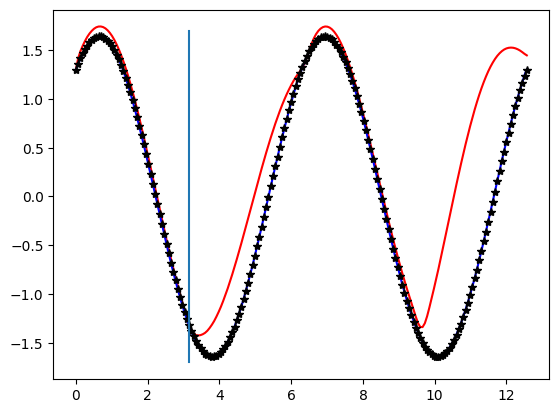

In [ ]:
import torch
print(pred[0])

pred_base_nn = global_var.solution_guess_nn(torch.from_numpy(t).reshape(-1, 1).float())

plt.plot(t, pred[1], color = 'r')
plt.plot(t, pred_base_nn.detach().numpy(), color = 'b')
plt.plot(t, x, '*', color = 'k')
plt.plot([np.pi, np.pi], [-1.7, 1.7])
plt.show()

In [ ]:
global_var.tensor_cache.memory_default['numpy'].keys()

dict_keys([('du/dx0', (1.0,)), ('u', (1.0,)), ('cos', (1.0, 1.0451132190723846, 0.0)), ('cos', (1.0, 1.0220103631666049, 0.0)), (('du/dx0', (1.0,)), ('u', (1.0,))), ('sin', (1.0, 0.9985195447902304, 0.0)), ('x_0', (2.0, 0.0)), ('x_0', (1.0, 0.0)), ('sin', (1.0, 1.0471178630046698, 0.0)), ('cos', (1.0, 1.046716747875297, 0.0)), ('sin', (1.0, 0.9761953879839909, 0.0)), ('cos', (1.0, 0.9519993654137203, 0.0))])

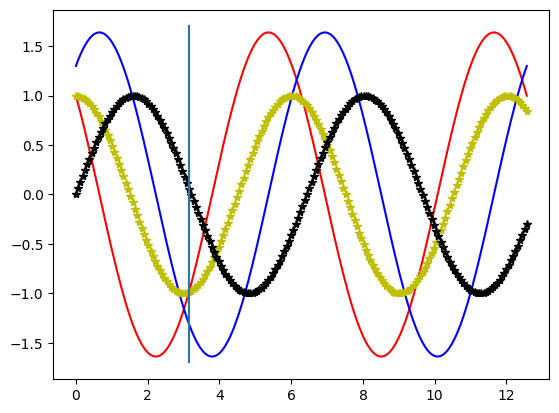

In [ ]:
plt.plot(t, global_var.tensor_cache.get(('du/dx0', (1.0,))), color = 'r')
plt.plot(t, global_var.tensor_cache.get(('u', (1.0,))), color = 'b')
plt.plot(t, global_var.tensor_cache.get(('cos', (1.0, 1.0451132190723846, 0.0))), '*', color = 'y')
plt.plot(t, global_var.tensor_cache.get(('sin', (1.0, 0.9761953879839909, 0.0))), '*', color = 'k')
plt.plot([np.pi, np.pi], [-1.7, 1.7])
plt.show()

The discovered equations can be accessed with ``EpdeSearch.equations()`` method. If the ``only_print = True``, than the equations will be printed in their text forms. 

Otherwise, they will be return: if the followup argument ``only_str`` is ``True``, than the equations are returned only in their symbolic string-form. If ``only_str = False``, than the equation in its program implementation ``epde.structure.main_structures.SoEq`` are returned.

In [ ]:
epde_search_obj.equations()



0-th non-dominated level


-0.013175025300367833 * u{power: 1.0} + 0.9892238974354812 * u{power: 1.0} * cos{power: 1.0, freq: 0.9568848121454095, dim: 0.0} + -0.0001611181862038159 * x_0{power: 3.0, dim: 0.0} + -1.45418738659447 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 0.9502407109385359, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 4}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.009025929135851003}} , with objective function values of [7.03603881 4.5       ] 

-0.04147267916214175 * u{power: 1.0} + 9.574790030415778e-05 * x_0{power: 3.0, dim: 0.0} * u{power: 1.0} + 0.9863331720490307 * u{power: 1.0} * cos{power: 1.0, freq: 0.9568848121454095, dim: 0.0} + -1.5035653104305782 = du/dx0{power: 1.0} * sin{power: 1.0, freq: 0.9502407109385359, dim: 0.0}
{'terms_number': {'optimizable': False, 'value': 4}, 'max_factors_in_term': {'optimizable': False, 'value': 

In [ ]:
res = epde_search_obj.equations(False)

In [ ]:
res[0][0].vals['u'].structure[0].structure[0]._evaluator

In [ ]:
res = epde_search_obj.equations(only_print=False, num = 3)

In [ ]:
factor = res[0][0].vals['u'].structure[0].structure[0]
system = res[0][0]
eq = res[0][0].vals['u']

In [ ]:
family = eq.pool.families_demand_equation[0]
family.variable

'u'

The particular solution of the ODE in addition to the governing equation $x \sin{(t)} + x' \cos{(t)} = 1,$ also matches the solution of equation $x' \sin{(t)}  - x \cos{(t)} = - 1.3$. With them having (in ideal case) the same fitness functions values, we can expect presence of at least one type of such results in the equation.

We can use visual analysis of the Pareto-optimal set of candidate equations, placed in the complexity-quality criteria space, to select the optimal equation. Method ``EpdeSearch.visualize_solutions()`` illustrates the first non-dominated set of solutions (i.e. Pareto frontier). With its help we can see, that equations like $x' \cdot \sin{(1.001 \; t)} = 9.997\cdot 10^{-1} x \cdot cos{(1.006 \; t)} + -1.274$ (may differ due to stochastic nature of evolutionary optimization) matches the knee point of a Pareto frontier curve. *Note* In some cases, only two equations are discovered, or if multiple simple equations are proposed, thus no knee point analysis.

$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(9.502\cdot 10^{-1}  x_{0.0}) = -1.318\cdot 10^{-2} u + 9.892\cdot 10^{-1} u \cdot cos^{1.0}(9.569\cdot 10^{-1}  x_{0.0}) + -1.611\cdot 10^{-4} (x_0)^{3.0} + -1.454 \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} \cdot sin^{1.0}(9.502\cdot 10^{-1}  x_{0.0}) = -4.147\cdot 10^{-2} u + 9.575\cdot 10^{-5} (x_0)^{3.0} \cdot u + 9.863\cdot 10^{-1} u \cdot cos^{1.0}(9.569\cdot 10^{-1}  x_{0.0}) + -1.504 \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} = -2.16\cdot 10^{-1} u + 9.215\cdot 10^{-1} x_0 + -7.298\cdot 10^{-2} (x_0)^{2.0} + -2.575 \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial u}{\partial x_0} = 2.496\cdot 10^{-1} u \cdot sin^{1.0}(1.024 x_{0.0}) + -2.67\cdot 10^{-1}  \end{eqnarray*}$


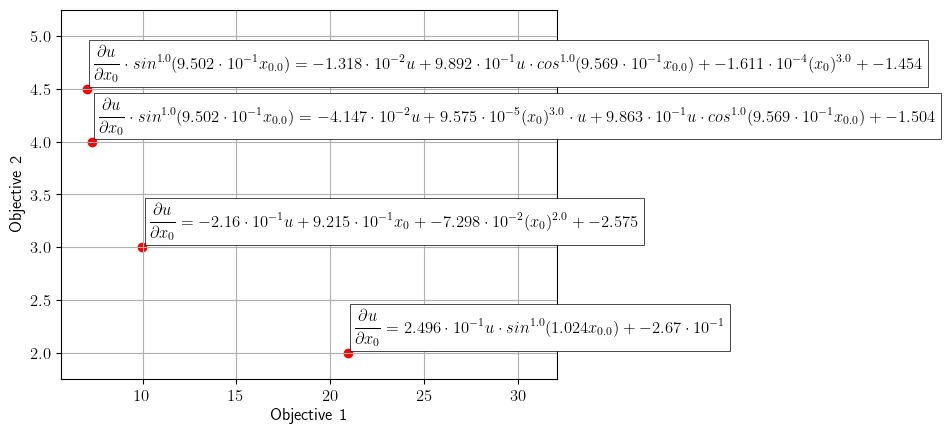

In [ ]:
epde_search_obj.visualize_solutions()

In [ ]:
tcache = epde_search_obj.cache[1]

In [ ]:
len(tcache.memory_default)

2

In [ ]:
tcache._deriv_codes

[((0, [0]), ('du/dx0', (1.0,))), ((0, [None]), ('u', (1.0,)))]

## Second order non-linear ODE

A more complex example of the problem can be posed by a linear non-homogeneous equation $x'' + \sin{(2t)} x' + 4 x = 1.5 t$. To get a synthetic dataset we can solve it with Runge-Kutta fourth order method. The particular solution matches the initial problem of $x|_{t = 0} = 0.8$, $x''|_{t = 0} = 2.0$ for domain $t \in [0, 16)$.

In [ ]:
def second_order_lODE_by_RK(initial : tuple, timestep : float, steps : int, g1 : Callable, 
                           g2 : Callable, g3 : Callable, g4 : Callable):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 = (g4(t) - g3(t)*res[step, 0] - g2(t)*res[step, 1]) / g1(t); y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = (g4(t) - g3(t)*x1 - g2(t)*y1) / g1(t); y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = (g4(t) - g3(t)*x2 - g2(t)*y2) / g1(t);
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = (g4(t) - g3(t)*x3 - g2(t)*y3) / g1(t)
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

In [ ]:
g1 = lambda x: 1.
g2 = lambda x: np.sin(2*x)
g3 = lambda x: 4.
g4 = lambda x: 1.5*x

step = 0.05; steps_num = 320
t = np.arange(start = 0., stop = step * steps_num, step = step)
solution = second_order_lODE_by_RK(initial=(0.8, 2.), timestep=step, steps=steps_num, 
                                  g1=g1, g2=g2, g3=g3, g4=g4)

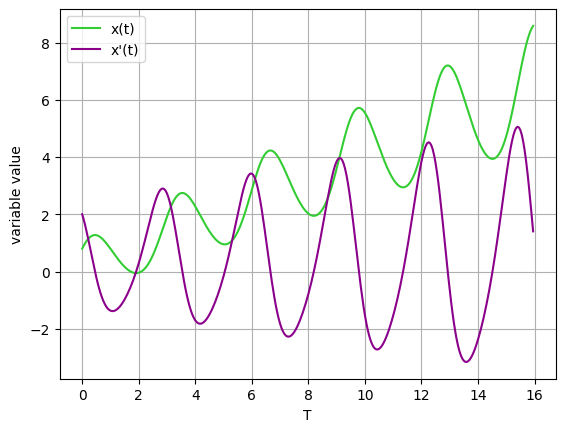

In [ ]:
plt.plot(t, solution[:, 0], label = 'x(t)', color = 'limegreen')
plt.plot(t, solution[:, 1], label = "x'(t)", color = 'darkmagenta')
plt.grid(); plt.legend()
plt.xlabel('T'); plt.ylabel('variable value')
plt.show()

While it can be insightful to analyze the process with the data-driven differential equation, occasionally it will be needed to predict the future state of the system, based on the equation. In this experiment we will split the input dataset into train ($t \in [0, 8)$) and test ($t \in [8, 16)$) parts. To validate the predicitive ability, the best equation will be integrated over the domain, using internal automaitic differential equation solution methods.

In [ ]:
def epde_discovery(t, x, diff_mode = 'FD'):
    dimensionality = x.ndim - 1
    

    epde_search_obj = epde.EpdeSearch(use_solver = True, dimensionality = dimensionality, boundary = 30,
                                      coordinate_tensors = [t,], verbose_params = {'show_iter_idx' : True})
    if diff_mode == 'ANN':
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 50000})
    elif diff_mode == 'poly':
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : False, 'sigma' : 1, 
                                                              'polynomial_window' : 3, 'poly_order' : 3}) 
    elif diff_mode == 'FD':
        epde_search_obj.set_preprocessor(default_preprocessor_type='FD')
    else:
        raise NotImplementedError('Incorrect differentiation mode selected.')
        
    eps = 5e-7
    popsize = 10
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=15)
    trig_tokens = epde.TrigonometricTokens(freq = (2 - eps, 2 + eps), 
                                           dimensionality = dimensionality)
    factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.65, 0.35]}

    custom_grid_tokens = epde.GridTokens(dimensionality = dimensionality, max_power=1)
    
    epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(2,),
                        equation_terms_max_number=6, data_fun_pow = 1, 
                        additional_tokens=[trig_tokens, custom_grid_tokens], 
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-6, 1e-2))

    epde_search_obj.equations(only_print = True, num = 1)
    
    '''
    Having insight about the initial ODE structure, we are extracting the equation with complexity of 5
    
    In other cases, you should call epde_search_obj.equations(only_print = True), or epde_search_obj.
    where the algorithm presents Pareto frontier of optimal equations.
    '''

    return epde_search_obj

In [ ]:
t_max = 160
t_train = t[:t_max]; t_test = t[t_max:] 
x_train = solution[:t_max, 0]; x_test = solution[t_max:, 0]

epde_search_obj = epde_discovery(t_train, x_train, 'FD')

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7e747b907770>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7e747b907770>
trig_token_params: VALUES = (0, 0)
Deriv orders after definition [[0], [0, 0]]
initial_shape (160,) derivs_tensor.shape (160, 2)
Size of linked labels is 3
self.tokens is ['du/dx0', 'd^2u/dx0^2']
Here, derivs order is {'du/dx0': [0], 'd^2u/dx0^2': [0, 0]}
self.tokens is ['u']
Here, derivs order is {'u': [None]}
The cardinality of defined token pool is [1 2 2 1]
Among them, the pool contains [1 2 1]
self.vars_demand_equation {'u'}
Creating new equation, sparsity value [0.00181275]
New solution accepted, confirmed 1/10 solutions.
Creating new equation, sparsity value [4.57348701e-06]
New solution accepted, confirmed 2/10 solutions.
Creating new equation, sparsity value [0.00021384]
New solution accepted, confirmed 3/10 solutions.
Creating new equation, sparsity value [0.00119647]
New solution accepted, confirmed 4/

KeyboardInterrupt: 

In [ ]:
epde_search_obj.visualize_solutions()

NameError: name 'epde_search_obj' is not defined

In [ ]:
epde_search_obj.equations()



0-th non-dominated level


1.4978908137281561 * t{power: 1.0, dim: 0.0} + 0.0 * d^2u/dx0^2{power: 1.0} * sin{power: 1.0, freq: 1.9999998994878334, dim: 0.0} + -3.9922835564790353 * u{power: 1.0} + 0.050454732853450264 * du/dx0{power: 1.0} * cos{power: 1.0, freq: 1.9999995026410626, dim: 0.0} + -0.9868391251501335 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 2.0000001669558607, dim: 0.0} + -0.031059382389109765 = d^2u/dx0^2{power: 1.0}
{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0019160411846225512}} , with objective function values of [0.01994216 6.        ] 

0.0 * t{power: 1.0, dim: 0.0} * cos{power: 1.0, freq: 1.9999995139795441, dim: 0.0} + -3.9681465338248225 * u{power: 1.0} + -0.9932498081255545 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 1.999999690491534, dim: 0.0} + 1.4955325941165816 * t{power: 1.0, dim: 0.0} 

In [ ]:
import epde.globals as global_var

from epde.interface.solver_integration import SolverAdapter


net = None

adapter = SolverAdapter(net=net, use_cache=False)
solution_model = adapter.solve_epde_system(system = epde_search_obj.get_equations_by_complexity(4.5)[0], 
                                           grids = None, boundary_conditions = None)
grid = global_var.grid_cache.get_all()[1]
g_fun_vals = global_var.grid_cache.g_func #.reshape(-1)

In the solver form declaration, default_domain mode flag is True
target_form shape is torch.Size([160, 1])
processing a single variable
obtained bconds: [<epde.interface.solver_integration.BOPElement object at 0x76359775c8c0>, <epde.interface.solver_integration.BOPElement object at 0x76359769a3c0>]
processing a single variable
Before grid creation [tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000,
        0.4500, 0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500,
        0.9000, 0.9500, 1.0000, 1.0500, 1.1000, 1.1500, 1.2000, 1.2500, 1.3000,
        1.3500, 1.4000, 1.4500, 1.5000, 1.5500, 1.6000, 1.6500, 1.7000, 1.7500,
        1.8000, 1.8500, 1.9000, 1.9500, 2.0000, 2.0500, 2.1000, 2.1500, 2.2000,
        2.2500, 2.3000, 2.3500, 2.4000, 2.4500, 2.5000, 2.5500, 2.6000, 2.6500,
        2.7000, 2.7500, 2.8000, 2.8500, 2.9000, 2.9500, 3.0000, 3.0500, 3.1000,
        3.1500, 3.2000, 3.2500, 3.3000, 3.3500, 3.4000, 3.4500, 3.5000, 3.5500,
        3

In [ ]:
solution_model.shape

(160, 1)

In [ ]:
for eq_idx, eq in enumerate(epde_search_obj.get_equations_by_complexity(4.5)[0].vals):
    referential_data = global_var.tensor_cache.get((eq.main_var_to_explain, (1.0,)))

    discr = (solution_model[..., eq_idx] - referential_data.reshape(solution_model[..., eq_idx].shape))

    discr = np.multiply(discr, g_fun_vals.reshape(discr.shape))
    rl_error = np.linalg.norm(discr, ord = 2)
    
    fitness_value = rl_error
    # if np.sum(eq.weights_final) == 0: 
    #     fitness_value /= self.params['penalty_coeff']

    eq.fitness_calculated = True
    eq.fitness_value = fitness_value

    # if global_var.verbose.plot_DE_solutions:
    #     plot_data_vs_solution(self.adapter.convert_grid(grid),
    #                             data = referential_data.reshape(solution[eq_idx, ...].shape), 
    #                             solution = solution[eq_idx, ...])

In [ ]:
ref_data = referential_data.reshape(solution_model[..., eq_idx].shape)

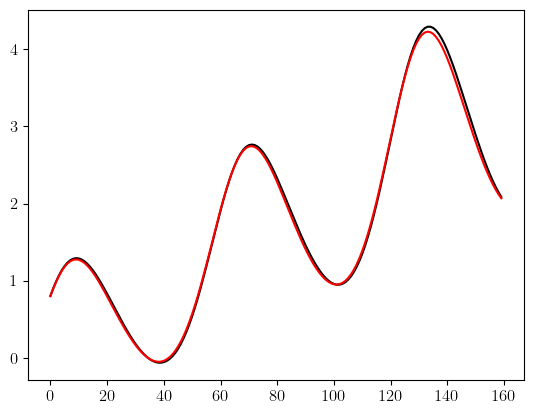

In [ ]:
plt.plot(solution_model, color = 'k')
plt.plot(ref_data, color = 'r')
plt.show()

While there are multiple equations on the Pareto frontier, we can establish two candidates for the knee-points (for brevity they are denoted by their complexities: 4 and 4.5). The further increase in complexity does not provide significant error decrease, thus is not necessary. We shall analyze the process representation quality on the test dataset by solving initial value problem.

The equation with complexity of 4.5 is second-order, thus to solve it we need the function value and the solution derivatve

In [ ]:
import torch
from epde.interface.solver_integration import BoundaryConditions, BOPElement

eq_1 = epde_search_obj.get_equations_by_complexity(4.5)[0]
print(eq_1.text_form)

1.4955324464724358 * t{power: 1.0, dim: 0.0} + 0.0 * d^2u/dx0^2{power: 1.0} * du/dx0{power: 1.0} + -3.968146926359605 * u{power: 1.0} + 0.0 * u{power: 1.0} * t{power: 1.0, dim: 0.0} + -0.9932497612286777 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 1.999999506093066, dim: 0.0} + -0.02158770908923868 = d^2u/dx0^2{power: 1.0}
{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.003144179449085998}}


In [ ]:
def get_ode_bop(key, var, term, grid_loc, value):
    bop = BOPElement(axis = 0, key = key, term = term, power = 1, var = var)
    bop_grd_np = np.array([[grid_loc,]])
    bop.set_grid(torch.from_numpy(bop_grd_np).type(torch.FloatTensor))
    bop.values = torch.from_numpy(np.array([[value,]])).float()
    return bop

bop_u = get_ode_bop('u', 0, [None], t_test[0], x_test[0])

# Set derivative with central finite difference
bop_du = get_ode_bop('dudt', 0, [0,], t_test[0], (x_test[1] - x_train[-1])/(2*(t_test[1] - t_test[0])))   

In [ ]:
t_test.shape
t_test_oversampled = np.linspace(t_test[0], t_test[-1], 160)

In [ ]:
pred_u = epde_search_obj.predict(system=eq_1, boundary_conditions = [bop_u(), bop_du()],
                                 grid = [t_test,], mode='NN')

Using explicitly sent system of equations.
grid.shape is (160,)
target_form shape is torch.Size([160, 1])
grid.shape inside Domain is torch.Size([160, 1])
[2024-05-14 13:17:20.446732] initial (min) loss is 239.76341247558594
Step = 10000 loss = 0.277621.
[2024-05-14 13:19:48.210677] No improvement in 1000 steps
[2024-05-14 13:19:48.210765] Step = 15159 loss = 0.110160 normalized loss line= -0.000042x+1.262990. There was 1 stop dings already.
[2024-05-14 13:20:09.691486] No improvement in 1000 steps
[2024-05-14 13:20:09.691598] Step = 17455 loss = 0.087422 normalized loss line= 0.005672x+1.122424. There was 2 stop dings already.
[2024-05-14 13:20:22.351512] No improvement in 1000 steps
[2024-05-14 13:20:22.351780] Step = 18776 loss = 0.157699 normalized loss line= 0.000779x+0.667138. There was 3 stop dings already.
[2024-05-14 13:20:31.504933] No improvement in 1000 steps
[2024-05-14 13:20:31.505217] Step = 19776 loss = 0.185144 normalized loss line= 0.000182x+0.593334. There was 4 stop

In [ ]:
pred_u = pred_u.reshape(-1)

To evaluate the quality of obtained equation, we will check the MAPE error and visualize the solution oftest domain.

In [ ]:
if isinstance(pred_u, torch.Tensor):
    pred_u = pred_u.detach().numpy()

MAPE on the test dataset is 0.029684286473510485


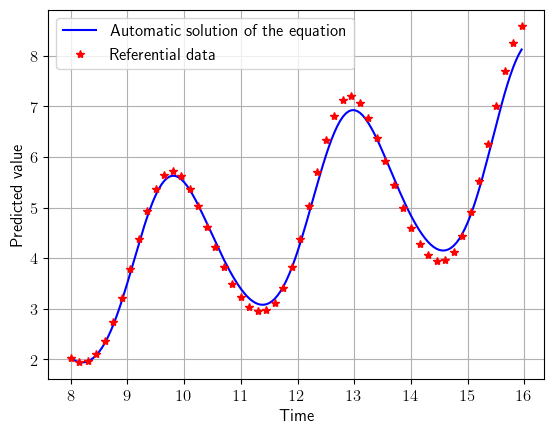

In [ ]:
print(f'MAPE on the test dataset is {np.mean(np.abs((pred_u - x_test)/x_test))}')

plt.plot(t_test, pred_u, color = 'b', label = 'Automatic solution of the equation')
plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.xlabel('Time'); plt.ylabel('Predicted value') 
plt.grid()
plt.legend()
plt.show()

In [ ]:
eq_2 = epde_search_obj.get_equations_by_complexity(4)[0]
eq_2.text_form

"0.0 * d^2u/dx0^2{power: 1.0} + -1.0624080820721236 * u{power: 1.0} * sin{power: 1.0, freq: 1.9999996981912465, dim: 0.0} + -0.21710586567205623 * t{power: 1.0, dim: 0.0} + 0.3259807845969001 * t{power: 1.0, dim: 0.0} * cos{power: 1.0, freq: 2.000000424084055, dim: 0.0} + 0.21934994682760084 * u{power: 1.0} + 1.2864748624370526 = du/dx0{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 6}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.65, 0.35]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.0026895703879134727}}"

This equation has the first order, thus only a single initial condition $u|_{t = t_{val, 0}}$ is enough, and we get it from the data.

In [ ]:
pred_u = epde_search_obj.predict(system=eq_2, boundary_conditions = [bop_u()], # })
                                 grid = [t_test,], mode='NN', use_fourier = True, fft_params = {'L' : [4,], 
                                                                                                'M' : [3,]},
                                 compiling_params = {'tol' : 0.005})

Using explicitly sent system of equations.
grid.shape is (160,)
target_form shape is torch.Size([160, 1])
[2024-04-10 13:06:17.713854] initial (min) loss is 484.7067565917969
[2024-04-10 13:06:19.980834] Oscillation near the same loss
[2024-04-10 13:06:19.981127] Step = 300 loss = 1.285648 normalized loss line= -0.000000x+1.000003. There was 1 stop dings already.
[2024-04-10 13:06:20.785312] Oscillation near the same loss
[2024-04-10 13:06:20.785405] Step = 400 loss = 1.285642 normalized loss line= 0.000000x+1.000002. There was 2 stop dings already.
[2024-04-10 13:06:22.424131] Oscillation near the same loss
[2024-04-10 13:06:22.424485] Step = 600 loss = 1.285630 normalized loss line= -0.000000x+1.000005. There was 3 stop dings already.
[2024-04-10 13:06:23.342758] Oscillation near the same loss
[2024-04-10 13:06:23.342850] Step = 700 loss = 1.285620 normalized loss line= -0.000000x+1.000005. There was 4 stop dings already.
[2024-04-10 13:06:24.151050] Oscillation near the same loss
[2

MAPE on the test dataset is 1.7942529267020053


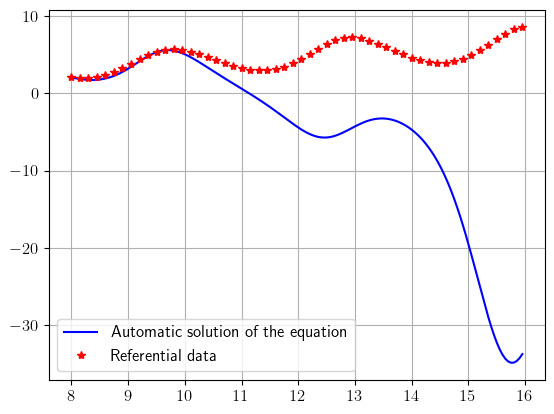

In [ ]:
print(f'MAPE on the test dataset is {np.mean(np.abs((pred_u - x_test)/x_test))}')

plt.plot(t_test, pred_u, color = 'b', label = 'Automatic solution of the equation')
plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.grid()
plt.legend()
plt.show()

In the result we can see, that the equation like $1.42 t - 3.81 u -0.96 u'' + 0.007 = u' \sin{(2.0 t)}$ can decently describe the process, while the alternative equation is not representative enough.

## Van der Pol oscillator

The problem of non-linear ordinary differential equations discovery can be demonstrated with the Van der Pol oscillator. Initially introduced to describe the relaxation-oscillation cycle produced by the electromagnetic field, the model has found applications in other spheres of science, such as biology or seismology. Its state is governed by equation $u'' + \mathcal{E}(u^2 - 1)u' + u = 0$, where $\mathcal{E}$ is a positive constant (in the example we will use $\mathcal{E} = 0.2$). To prepare synthetic dataset we will again use Runge-Kutta method:

In [ ]:
def VdP_by_RK(initial: tuple, timestep: float, steps: int, epsilon: float):
    res = np.full(shape = (steps, 2), fill_value = initial, dtype=np.float64)
    for step in range(steps-1):
        t = step*timestep
        k1 = res[step, 1] ; x1 = res[step, 0] + timestep/2. * k1
        l1 =  - epsilon*(res[step, 0]**2 - 1)*res[step, 1] - res[step, 0]; y1 = res[step, 1] + timestep/2. * l1

        k2 = y1; x2 = res[step, 0] + timestep/2. * k2
        l2 = - epsilon*(x1**2 - 1)*y1 - x1; y2 = res[step, 1] + timestep/2. * l2

        k3 = y2
        l3 = - epsilon*(x2**2 - 1)*y2 - x2
        
        x3 = res[step, 0] + timestep * k1 - 2 * timestep * k2 + 2 * timestep * k3
        y3 = res[step, 1] + timestep * l1 - 2 * timestep * l2 + 2 * timestep * l3
        k4 = y3
        l4 = - epsilon*(x3**2 - 1)*y3 - x3
        
        res[step+1, 0] = res[step, 0] + timestep / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
        res[step+1, 1] = res[step, 1] + timestep / 6. * (l1 + 2 * l2 + 2 * l3 + l4)
    return res

def prepare_VdP_data(initial = (np.sqrt(3)/2., 1./2.), step = 0.05, steps_num = 640, epsilon = 0.2):
    t = np.arange(start = 0., stop = step * steps_num, step = step)
    solution = VdP_by_RK(initial=initial, timestep=step, steps=steps_num, 
                                      epsilon=epsilon)
    return t, solution

In [ ]:
def epde_discovery_as_ode(t, x, use_ann:bool = False):
    dimensionality = x.ndim - 1
    epde_search_obj = epde.EpdeSearch(use_solver = False, dimensionality = dimensionality, boundary = 50,
                                           coordinate_tensors = [t,], verbose_params = {'show_iter_idx' : False})
    if use_ann:
        epde_search_obj.set_preprocessor(default_preprocessor_type='ANN',
                                         preprocessor_kwargs={'epochs_max' : 35000})
    else:
        epde_search_obj.set_preprocessor(default_preprocessor_type='poly',
                                         preprocessor_kwargs={'use_smoothing' : True, 'sigma' : 1, 
                                                              'polynomial_window' : 15, 'poly_order' : 12})
    popsize = 12
    epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=125)
    
    factors_max_number = {'factors_num' : [1, 2, 3], 'probas' : [0.4, 0.3, 0.3]}
    
    epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(3,),
                        equation_terms_max_number=6, data_fun_pow = 2,
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=(1e-13, 1e0))
    
    epde_search_obj.equations(only_print = True, num = 1)
    
    return epde_search_obj

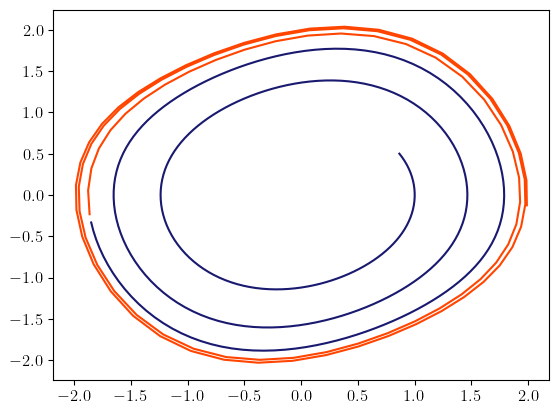

In [ ]:
t, x_stacked = prepare_VdP_data()
t_max = 320
x, y = x_stacked[:, 0], x_stacked[:, 1]
t_train, t_test = t[:t_max], t[:t_max]
x_train, x_test = x[:t_max], x[t_max:]
y_train, y_test = y[:t_max], y[t_max:]
plt.plot(x_train, y_train, color = 'midnightblue')
plt.plot(x_test[::3], y_test[::3], color = 'orangered')
plt.show()

In [ ]:
epde_search_obj = epde_discovery_as_ode(t_train, x_train, False)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f6b2e0894f0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f6b2e0894f0>
Deriv orders after definition [[0], [0, 0], [0, 0, 0]]
320
initial_shape (320,) derivs_tensor.shape (320, 3)
self.tokens is ['du/dx0', 'd^2u/dx0^2', 'd^3u/dx0^3']
Here, derivs order is {'du/dx0': [0], 'd^2u/dx0^2': [0, 0], 'd^3u/dx0^3': [0, 0, 0]}
self.tokens is ['u']
Here, derivs order is {'u': [None]}
The cardinality of defined token pool is [1 3]
Among them, the pool contains [1 3]
self.vars_demand_equation {'u'}
Creating new equation, sparsity value [3.76342975e-06]
New solution accepted, confirmed 1/12 solutions.
Creating new equation, sparsity value [3.53590374e-06]
New solution accepted, confirmed 2/12 solutions.
Creating new equation, sparsity value [5.89895174e-10]
New solution accepted, confirmed 3/12 solutions.
Creating new equation, sparsity value [0.00031145]
New solution accepted, confirmed 4/12 sol

$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = 1.991\cdot 10^{-1} \frac{\partial u}{\partial x_0} + -1.991\cdot 10^{-1} \left(u\right)^{2.0} \cdot \frac{\partial u}{\partial x_0} + -1.0u + -1.264\cdot 10^{-5}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} \cdot u = -1.013\left(u\right)^{2.0} + 7.106\cdot 10^{-3}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = 1.992\cdot 10^{-1} \frac{\partial u}{\partial x_0} + -1.0u + -1.998\cdot 10^{-1} \frac{\partial u}{\partial x_0} \cdot \left(u\right)^{2.0} + -7.472\cdot 10^{-4} u \cdot \frac{\partial u}{\partial x_0} \cdot \frac{\partial ^2u}{\partial x_0^2} + -1.71\cdot 10^{-5}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} = -1.007u + 1.034\cdot 10^{-2}  \end{eqnarray*}$
$\begin{eqnarray*} \frac{\partial ^2u}{\partial x_0^2} \cdot u = -1.013\left(u\right)^{2.0} + -8.059\cdot 10^{-3} u + 5.781\cdot 10^{-3}  \end{eqnarray*}$


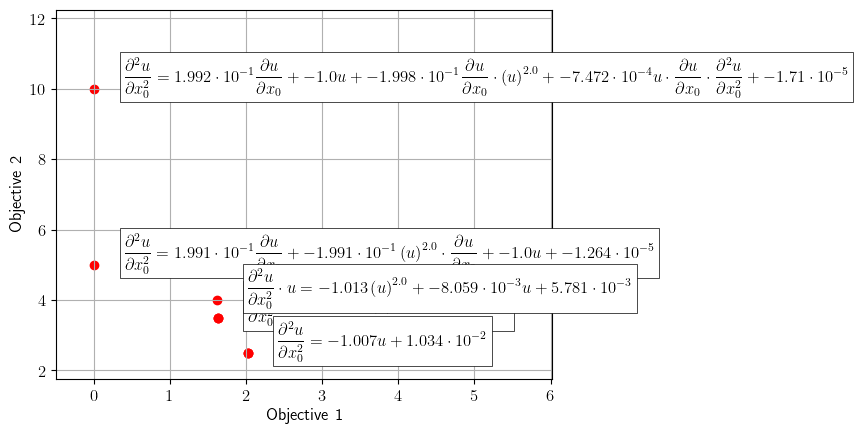

In [ ]:
epde_search_obj.visualize_solutions()

Let's extract equations, that can be useful for system description: 

*Note*: during other example launches, the discovered equations may be different. To proceed, adopt getting equations by complexities, according to the Pareto frontier.

In [ ]:
eq_compl_5 = epde_search_obj.get_equations_by_complexity(5)[0]
eq_compl_4 = epde_search_obj.get_equations_by_complexity(4)[0]
eq_compl_10 = epde_search_obj.get_equations_by_complexity(10)[0]

In [ ]:
eq_compl_4

The Pareto frontier is concave, having the relatively simple yet very descriptive equation, matching the equation $u'' = -u + 0.2 u' - 0.2 u^2 u' + \delta$, $\delta << 1$ which we will consider as a useful equation-based model of the process.

Even though we already know, that it is very similar to the equation, from which we generated the data, we should still examine its predictive properties. Let's solve the equation with solver:

In [ ]:
import torch
from epde.interface.solver_integration import BoundaryConditions, BOPElement

def get_ode_bop(key, var, term, grid_loc, value):
    bop = BOPElement(axis = 0, key = key, term = term, power = 1, var = var)
    bop_grd_np = np.array([[grid_loc,]])
    bop.set_grid(torch.from_numpy(bop_grd_np).type(torch.FloatTensor))
    bop.values = torch.from_numpy(np.array([[value,]])).float()
    return bop

In [ ]:
bop_u = get_ode_bop('u', grid_loc = t_test[0], value = x_test[0], term = [None], var = 0)
bop_dudt = get_ode_bop('dudt', grid_loc = t_test[0], value = y_test[0], term = [0], var = 0)

#get solution for equation with complexity 5
pred_u_compl_5 = epde_search_obj.predict(system=eq_compl_5, boundary_conditions=[bop_u(), bop_dudt()], 
                                         grid = [t_test,], mode='NN', use_fourier = True, fft_params = {'L' : [4,], 
                                                                                                        'M' : [3,]},
                                         compiling_params = {'tol' : 0.005})
pred_u_compl_5 = pred_u_compl_5.reshape(pred_u_compl_5.size)

#get solution for equation with complexity 4
pred_u_compl_4 = epde_search_obj.predict(system=eq_compl_4, boundary_conditions=[bop_u(), bop_dudt()], 
                                         grid = [t_test,], mode='NN', use_fourier = True, fft_params = {'L' : [4,], 
                                                                                                        'M' : [3,]},
                                         compiling_params = {'tol' : 0.005})
pred_u_compl_4 = pred_u_compl_4.reshape(pred_u_compl_4.size)

#get solution for equation with complexity 10
pred_u_compl_10 = epde_search_obj.predict(system=eq_compl_10, boundary_conditions=[bop_u(), bop_dudt()], 
                                          grid = [t_test,], mode='NN', use_fourier = True, fft_params = {'L' : [4,], 
                                                                                                         'M' : [3,]},
                                          compiling_params = {'tol' : 0.005})
pred_u_compl_10 = pred_u_compl_10.reshape(pred_u_compl_10.size)

Using explicitly sent system of equations.
grid.shape is (320,)
target_form shape is torch.Size([320, 1])
[2024-04-10 13:54:00.819254] initial (min) loss is 157.35760498046875
[2024-04-10 13:55:28.529477] No improvement in 1000 steps
[2024-04-10 13:55:28.529590] Step = 6462 loss = 0.091874 normalized loss line= -0.000095x+0.885530. There was 1 stop dings already.
Step = 10000 loss = 0.071435.
Step = 20000 loss = 0.012310.
[2024-04-10 13:58:51.330534] No improvement in 1000 steps
[2024-04-10 13:58:51.330632] Step = 21213 loss = 0.009663 normalized loss line= 0.000176x+1.206889. There was 2 stop dings already.
[2024-04-10 13:59:33.872058] No improvement in 1000 steps
[2024-04-10 13:59:33.872400] Step = 24264 loss = 0.008175 normalized loss line= 0.004258x+1.090927. There was 3 stop dings already.
[2024-04-10 13:59:51.966097] No improvement in 1000 steps
[2024-04-10 13:59:51.966425] Step = 25590 loss = 0.011441 normalized loss line= -0.000267x+0.801283. There was 4 stop dings already.
[20

MAPE on the test dataset for eq with $C = 10$ is 0.10144529768587558
MAPE on the test dataset for eq with $C = 5$ is 0.05921013441446753
MAPE on the test dataset for eq with $C = 4$ is 0.9145161732228347


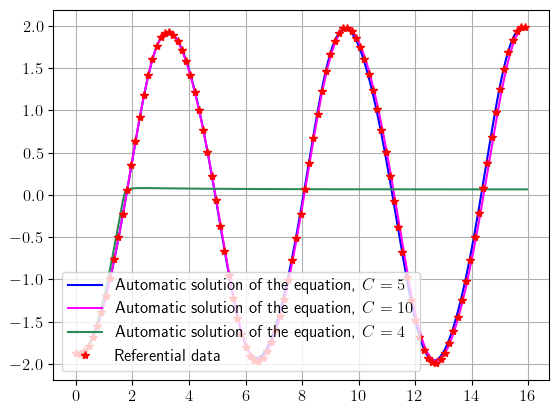

In [ ]:
mae_compl_4 = np.mean(np.abs((pred_u_compl_4 - x_test)/x_test))
mae_compl_5 = np.mean(np.abs((pred_u_compl_5 - x_test)/x_test))
mae_compl_10 = np.mean(np.abs((pred_u_compl_10 - x_test)/x_test))

print(f'MAPE on the test dataset for eq with $C = 10$ is {mae_compl_10}')
print(f'MAPE on the test dataset for eq with $C = 5$ is {mae_compl_5}')
print(f'MAPE on the test dataset for eq with $C = 4$ is {mae_compl_4}')

plt.plot(t_test, pred_u_compl_5, color = 'b', label = 'Automatic solution of the equation, $C = 5$')
plt.plot(t_test, pred_u_compl_10, color = 'magenta', label = 'Automatic solution of the equation, $C = 10$')
plt.plot(t_test, pred_u_compl_4, color = 'seagreen', label = 'Automatic solution of the equation, $C = 4$')

plt.plot(t_test[::3], x_test[::3], '*', color = 'r', label = 'Referential data')
plt.grid()
plt.legend(loc = 'lower left')
plt.show()

Here, we can notice, that the "correct" governing equation, which closely matches the Van der Pol equation, has the lowest MAPE metric on the test dataset, even outperforming the equations with higher complexities. The equation with lower complexity can represent only the averaged values of the system. Thus, we can select the equation like $u'' = -u + 0.2 u' - 0.2 u^2 u' + \delta$ for system representation.